# Imports

In [17]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from time import time
from torchvision import datasets, transforms
from torch import nn, optim
from tqdm import tqdm
import os 

# MNIST Data

In [18]:
# convert images to tensors 
# scale data between 0 and 1 
# normalize data 

transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,)),
                              ])

trainset = datasets.MNIST('./DigitRecognitionData/Train/', download=True, train=True, transform=transform)
valset = datasets.MNIST('./DigitRecognitionData/Valid/', download=True, train=False, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
valloader = torch.utils.data.DataLoader(valset, batch_size=64, shuffle=True)

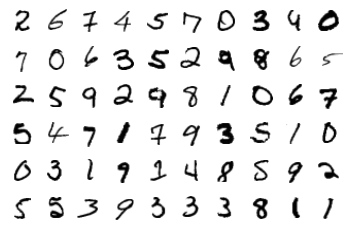

In [19]:
figure = plt.figure()
num_of_images = 60

dataiter = iter(trainloader)
images, labels = next(dataiter)

for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

# Without PyTorch Optimization

In [20]:
class NeuralNetwork:
    torch.manual_seed(42)
    
    def __init__(self, input_size, hidden_layers, output_size):
        self.input_size = input_size
        self.hidden_layers = hidden_layers
        self.output_size = output_size
        self.activation_function = self.sigmoid

        # Initialize weights and biases
        self.weights = [torch.randn(input_size, hidden_layers[0])]
        self.biases = [torch.zeros(hidden_layers[0])]

        for i in range(1, len(hidden_layers)):
            self.weights.append(torch.randn(hidden_layers[i-1], hidden_layers[i]))
            self.biases.append(torch.zeros(hidden_layers[i]))

        self.weights.append(torch.randn(hidden_layers[-1], output_size))
        self.biases.append(torch.zeros(output_size))

    def sigmoid(self, x):
        return 1 / (1 + torch.exp(-x))

    def softmax(self, x):
        exp_values = torch.exp(x - torch.max(x, dim=1, keepdim=True)[0])
        return exp_values / torch.sum(exp_values, dim=1, keepdim=True)

    def relu(self, x):
        return torch.max(x, torch.zeros_like(x))

    def forward(self, x):
        self.inputs = [x]
        self.z_values = []
        self.activations = []

        # Forward propagation
        for i in range(len(self.hidden_layers) + 1):
            z = np.matmul(x, self.weights[i]) + self.biases[i]
            self.z_values.append(z)

            if i == len(self.hidden_layers):
                x = self.softmax(z)
            else:
                x = self.activation_function(z)

            self.inputs.append(x)
            self.activations.append(x)

        return x

    def backward(self, x, y, learning_rate):
        # Backward propagation
        output_error = x - y
        delta = output_error * x * (1 - x)

        for i in reversed(range(len(self.hidden_layers) + 1)):
            if i == len(self.hidden_layers):
                self.weights[i] -= learning_rate * torch.mm(self.activations[i-1].t(), delta)
                self.biases[i] -= learning_rate * torch.sum(delta, dim=0)
            else:
                delta = torch.mm(delta, self.weights[i+1].t()) * self.activations[i] * (1-self.activations[i])
                self.weights[i] -= learning_rate * torch.mm(self.inputs[i].t(), delta)
                self.biases[i] -= learning_rate * torch.sum(delta, dim=0)

    def train(self, train_loader, epochs, learning_rate):
        loss = []
        for epoch in range(epochs):
            for inputs, labels in train_loader:
                inputs = inputs.view(inputs.shape[0], -1)
                labels_one_hot = torch.eye(self.output_size)[labels]

                output = self.forward(inputs)
                self.backward(output, labels_one_hot, learning_rate)

            print(f'Epoch {epoch + 1}/{epochs}, Loss: {torch.mean((output - labels_one_hot)**2).item()}')
            loss.append(torch.mean((output - labels_one_hot)**2).item())
            
        return loss 
    
    def test(self, val_loader):
        correct = 0
        total = 0

        
        for inputs, labels in val_loader:
            inputs = inputs.view(inputs.shape[0], -1)
            outputs = self.forward(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        accuracy = correct / total
        print(f'Test Accuracy: {accuracy * 100:.2f}%')

In [21]:
# Define neural network parameters
input_size = 28 * 28
hidden_layers = [128, 64, 32, 16]
output_size = 10
learning_rate = 0.1
epochs = 15

# Initialize and train the neural network with the ReLU activation function
model = NeuralNetwork(input_size, hidden_layers, output_size)
loss_without_pytorch = model.train(trainloader, epochs=epochs, learning_rate=learning_rate)

Epoch 1/15, Loss: 0.03394361957907677
Epoch 2/15, Loss: 0.02763538621366024
Epoch 3/15, Loss: 0.031978536397218704
Epoch 4/15, Loss: 0.018057215958833694
Epoch 5/15, Loss: 0.016767671331763268
Epoch 6/15, Loss: 0.025432372465729713
Epoch 7/15, Loss: 0.012812480330467224
Epoch 8/15, Loss: 0.0006215268513187766
Epoch 9/15, Loss: 0.011103910394012928
Epoch 10/15, Loss: 0.00545669998973608
Epoch 11/15, Loss: 0.009509043768048286
Epoch 12/15, Loss: 0.005006410181522369
Epoch 13/15, Loss: 0.0044894153252244
Epoch 14/15, Loss: 0.012010094709694386
Epoch 15/15, Loss: 0.009998510591685772


In [22]:
model.test(valloader)

Test Accuracy: 93.54%


In [23]:
def view_classify(img, ps):
    ''' Function for viewing an image and it's predicted classes.
    '''
    ps = ps.data.numpy().squeeze()

    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
    ax1.imshow(img.resize_(1, 28, 28).numpy().squeeze())
    ax1.axis('off')
    ax2.barh(np.arange(10), ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(10))
    ax2.set_yticklabels(np.arange(10))
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)
    plt.tight_layout()

# With Pytorch Training and Optimization

In [24]:
input_size = 784
hidden_sizes = [128, 64]
output_size = 10

model = nn.Sequential(nn.Linear(input_size, hidden_sizes[0]),
                      nn.ReLU(),
                      nn.Linear(hidden_sizes[0], hidden_sizes[1]),
                      nn.ReLU(),
                      nn.Linear(hidden_sizes[1], output_size),
                      nn.LogSoftmax(dim=1))
print(model)

Sequential(
  (0): Linear(in_features=784, out_features=128, bias=True)
  (1): ReLU()
  (2): Linear(in_features=128, out_features=64, bias=True)
  (3): ReLU()
  (4): Linear(in_features=64, out_features=10, bias=True)
  (5): LogSoftmax(dim=1)
)


In [25]:
criterion = nn.NLLLoss()

In [26]:
optimizer = optim.SGD(model.parameters(), lr=0.003, momentum=0.9)
time0 = time()
epochs = 15
loss_with_pytorch = []

for e in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        # Flatten MNIST images into a 784 long vector
        images = images.view(images.shape[0], -1)
    
        # Training pass
        optimizer.zero_grad()
        
        output = model(images)
        loss = criterion(output, labels)
        
        #This is where the model learns by backpropagating
        loss.backward()
        
        #And optimizes its weights here
        optimizer.step()
        
        running_loss += loss.item()
    else:
        print("Epoch {} - Training loss: {}".format(e, running_loss/len(trainloader)))
        loss_with_pytorch.append(running_loss/len(trainloader))
print("\nTraining Time (in minutes) =",(time()-time0)/60)

Epoch 0 - Training loss: 0.6235878504415565
Epoch 1 - Training loss: 0.2790682416067703
Epoch 2 - Training loss: 0.21456284390917338
Epoch 3 - Training loss: 0.17195048791838924
Epoch 4 - Training loss: 0.144612338934054
Epoch 5 - Training loss: 0.12436978402795759
Epoch 6 - Training loss: 0.10871234541333942
Epoch 7 - Training loss: 0.09666639631554516
Epoch 8 - Training loss: 0.0877963199542323
Epoch 9 - Training loss: 0.07882855307789388
Epoch 10 - Training loss: 0.07352157882121858
Epoch 11 - Training loss: 0.06580725485143234
Epoch 12 - Training loss: 0.06052984315197049
Epoch 13 - Training loss: 0.057259533527507775
Epoch 14 - Training loss: 0.05225883274108791

Training Time (in minutes) = 3.2743167837460834


In [27]:
correct_count, all_count = 0, 0
for images,labels in valloader:
    for i in range(len(labels)):
        img = images[i].view(1, 784)
        with torch.no_grad():
            logps = model(img)

    
        ps = torch.exp(logps)
        probab = list(ps.numpy()[0])
        pred_label = probab.index(max(probab))
        true_label = labels.numpy()[i]
        if(true_label == pred_label):
            correct_count += 1
        all_count += 1

print("Number Of Images Tested =", all_count)
print("\nModel Accuracy =", (correct_count/all_count))

Number Of Images Tested = 10000

Model Accuracy = 0.9723


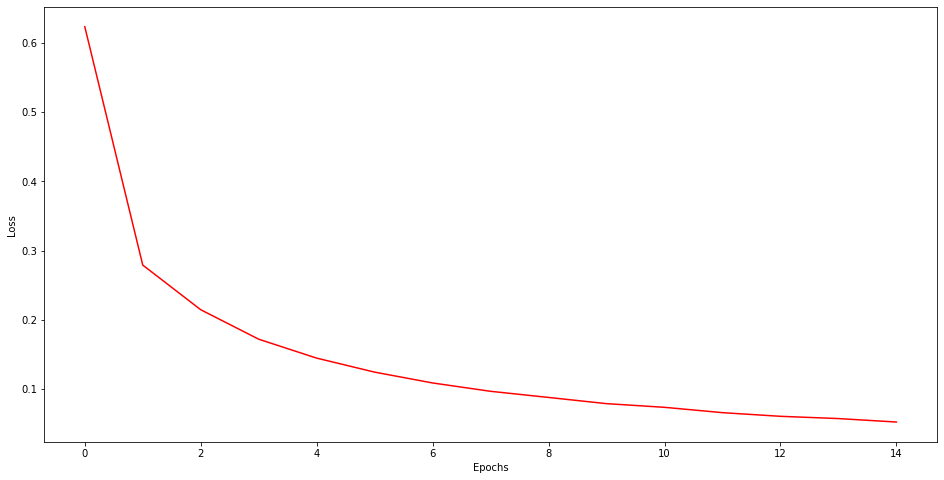

In [28]:
plt.figure(figsize=(16, 8))
plt.plot(range(0, 15), loss_with_pytorch, 'red')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.savefig("./Images/with_sgd_loss.pdf")
plt.show()

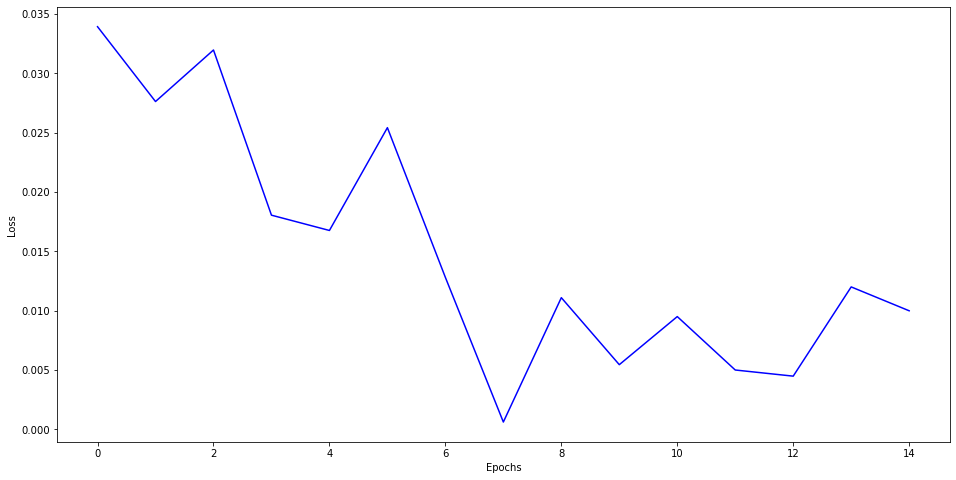

In [30]:
plt.figure(figsize=(16, 8))
plt.plot(range(0, 15), loss_without_pytorch, 'blue')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.savefig("./Images/without_sgd_loss.pdf")